# CAPM(Capital Asset Pricing Model)
- 주식의 가격에 대한 이론인가요? **No**
- 자산의 기대수익률에 대한 이론

$$ E[R_p] = R_f + \beta(E[R_M] - R_f) $$

- $ E[R_p] $ = 포트폴리오 기대수익률

- $ R_f $ = 무위험 수익률

- $ E[R_M] $ = 시장 기대수익률(대부분 index를 사용)

$$ \beta_p = \frac{Cov(R_p - R_f, R_M - R_f)}{Var(R_M - R_f)} $$

- $ \beta_p $에 대한 가장 간단한 Estimate : Linear Regression을 활용하는 것 

$$ r_P = \alpha_P + \beta_P r_M + \epsilon_P $$

- $ r_P $ = 포트폴리오 초과 수익률
- $ r_M $ = 시장의 초과 수익률
- $\beta$를 추정하는 방법
    - Bayesian
    
$$ r_P = \beta_P r_M + \epsilon_P $$

- $Cov(\epsilon_P, r_M)$는 0이므로,

$$ Var(r_P) = \sigma^2_P = \beta^2_P \sigma^2_M + Var(\epsilon_P) $$

* 몇가지 가정
    - $ E[epsilon_P] = 0 $
    - $ E[r_p] = \mu_p = \beta_P E[r_M] $

In [2]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp

In [3]:
# KOSPI200 => KS200
# Individual Asset : 삼성전자(005930), SK하이닉스(000660), 오뚜기(007310)
# 무위험자산(현금성자산) : KODEX단기채권(153130), KOSEF단기자금(130730)

In [5]:
market = fdr.DataReader("KS200", start="2019-1-1", end="2019-12-31")[['Close']]
se = fdr.DataReader("005930", start="2019-1-1", end="2019-12-31")[['Close']]
skh = fdr.DataReader("000660", start="2019-1-1", end="2019-12-31")[['Close']]
otg = fdr.DataReader("007310", start="2019-1-1", end="2019-12-31")[['Close']]
cash = fdr.DataReader("130730", start="2019-1-1", end="2019-12-31")[['Close']]

In [10]:
cash.head()

,Close
Date,
2019-01-02,97655
2019-01-03,97675
2019-01-04,97685
2019-01-07,97695
2019-01-08,97700


In [17]:
def log_return(df):
    return np.log(df / df.shift(1)).fillna(0)

In [21]:
# 수익률
market_rtn = log_return(market)
market_rtn.columns = ['market']
se_rtn = log_return(se)
se_rtn.columns = ['se']
skh_rtn = log_return(skh)
skh_rtn.columns = ['skh']
otg_rtn = log_return(otg)
otg_rtn.columns = ['otg']
cash_rtn = log_return(cash)
cash_rtn.columns = ['cash']

In [37]:
rtns = [market_rtn, se_rtn, skh_rtn, otg_rtn, cash_rtn]

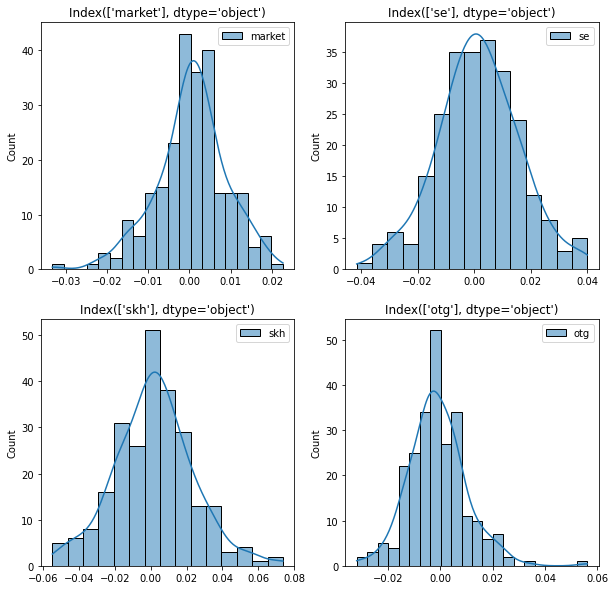

In [33]:
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.histplot(rtns[i], kde=True)
    plt.title(rtns[i].columns)
plt.show()

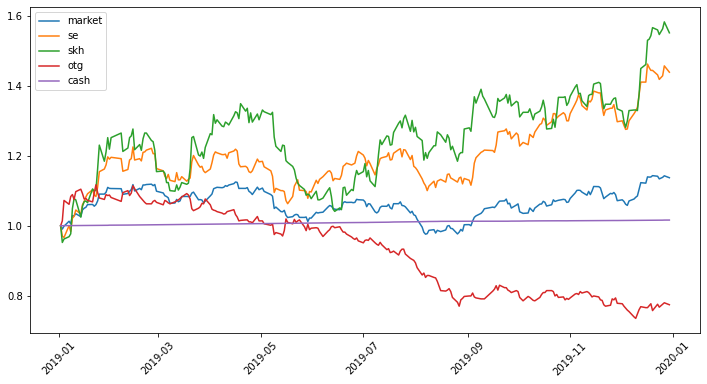

In [39]:
# 누적 수익률
plt.figure(figsize=(12,6))
for rtn in rtns:
    plt.plot(np.exp(rtn.cumsum()), label=rtn.columns[0])
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [47]:
# 수익률
rtn_df = pd.concat(rtns, axis=1)

excess_market = rtn_df.market - rtn_df.cash
excess_se = rtn_df.se - rtn_df.cash
excess_otg = rtn_df.otg - rtn_df.cash
excess_skh = rtn_df.skh - rtn_df.cash
excess_rtn_df = pd.concat([cash_rtn, excess_market, excess_se, excess_otg, excess_skh], axis=1)
excess_rtn_df.columns = ['cash', 'market', 'se', 'otg', 'skh']
excess_rtn_df.head()

,cash,market,se,otg,skh
Date,,,,,
2019-01-02,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-03,0.000205,-0.009777,-0.030331,0.013665,-0.049243
2019-01-04,0.000102,0.008152,-0.004100,0.056137,0.010243
2019-01-07,0.000102,0.014066,0.034022,-0.010574,0.006735
2019-01-08,0.000051,-0.007419,-0.016968,0.020783,0.008431


<AxesSubplot:xlabel='Date'>

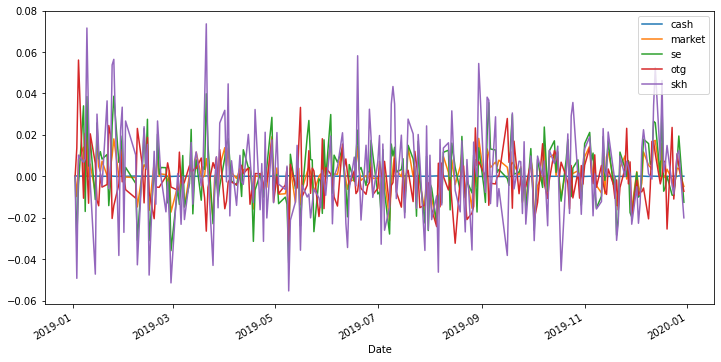

In [48]:
excess_rtn_df.plot(figsize=(12,6))

In [55]:
X = sm.add_constant(excess_market)
X.columns = ['constant', 'market']

In [56]:
model_se = sm.OLS(excess_se, X)
result_se = model_se.fit()
result_se.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     709.1
Date:                Wed, 20 Jul 2022   Prob (F-statistic):           3.77e-74
Time:                        01:11:46   Log-Likelihood:                 860.56
No. Observations:                 246   AIC:                            -1717.
Df Residuals:                     244   BIC:                            -1710.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.0007      0.000      1.581      0.115      -0.000       0.002
market         1.4712      0.055     26.630      0.000       1.362       1.580
==============================================================================
Omnibus:                        8.218   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.235
Skew:                           0.381   Prob(JB):                       0.0163
Kurtosis:                       3.470   Cond. No.                         118.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
model_otg = sm.OLS(excess_otg, X)
result_otg = model_otg.fit()
result_otg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     9.594
Date:                Wed, 20 Jul 2022   Prob (F-statistic):            0.00218
Time:                        01:11:46   Log-Likelihood:                 760.32
No. Observations:                 246   AIC:                            -1517.
Df Residuals:                     244   BIC:                            -1510.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -0.0012      0.001     -1.739      0.083      -0.003       0.000
market         0.2572      0.083      3.097      0.002       0.094       0.421
==============================================================================
Omnibus:                       39.188   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.349
Skew:                           0.740   Prob(JB):                     5.36e-21
Kurtosis:                       5.630   Cond. No.                         118.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
model_skh = sm.OLS(excess_skh, X)
result_skh = model_skh.fit()
result_skh.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     251.3
Date:                Wed, 20 Jul 2022   Prob (F-statistic):           2.21e-39
Time:                        01:11:47   Log-Likelihood:                 676.35
No. Observations:                 246   AIC:                            -1349.
Df Residuals:                     244   BIC:                            -1342.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.0009      0.001      0.881      0.379      -0.001       0.003
market         1.8518      0.117     15.852      0.000       1.622       2.082
==============================================================================
Omnibus:                        5.812   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                5.709
Skew:                           0.292   Prob(JB):                       0.0576
Kurtosis:                       3.464   Cond. No.                         118.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
model_skh = sm.OLS(excess_skh, X)
result_skh = model_skh.fit()
result_skh.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     251.3
Date:                Wed, 20 Jul 2022   Prob (F-statistic):           2.21e-39
Time:                        01:11:47   Log-Likelihood:                 676.35
No. Observations:                 246   AIC:                            -1349.
Df Residuals:                     244   BIC:                            -1342.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.0009      0.001      0.881      0.379      -0.001       0.003
market         1.8518      0.117     15.852      0.000       1.622       2.082
==============================================================================
Omnibus:                        5.812   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                5.709
Skew:                           0.292   Prob(JB):                       0.0576
Kurtosis:                       3.464   Cond. No.                         118.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
se_market_hat = excess_market * result_se.params['market']
se_resid_hat = excess_se - se_market_hat

otg_market_hat = excess_market * result_otg.params['market']
otg_resid_hat = excess_otg - otg_market_hat

skh_market_hat = excess_market * result_skh.params['market']
skh_resid_hat = excess_skh - skh_market_hat

In [72]:
expected_market = excess_market.mean() * 252
betas = np.array([0 , 1, result_se.params['market'], result_otg.params['market'], result_skh.params['market']])
expected_rf = cash_rtn.mean().cash * 252

In [75]:
expected_rtn = expected_rf + betas * expected_market

In [79]:
plt.rcParams['font.family'] = 'Malgun Gothic'
labels = ['무위험자산', '시장', '삼성전자', '오뚜기', 'SK하이닉스']

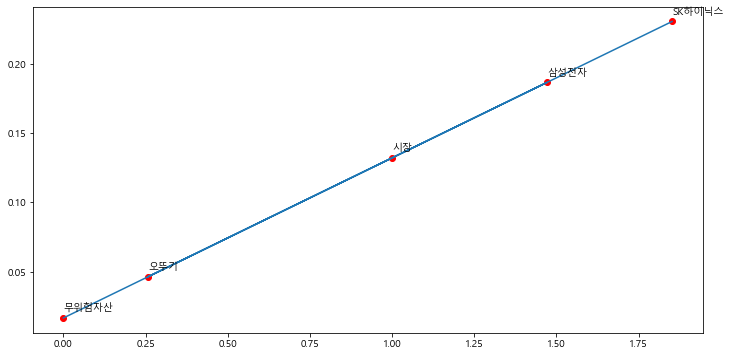

In [81]:
plt.figure(figsize=(12,6))
plt.plot(betas, expected_rtn)
plt.scatter(betas, expected_rtn, c='red')
for i, text in enumerate(expected_rtn):
    plt.annotate(labels[i], (betas[i], expected_rtn[i]+0.005))

In [82]:
model_bh = sm.OLS(excess_se - excess_market * result_se.params['market'], sm.add_constant(excess_market))
result_bh = model_bh.fit()
result_bh.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                     0.000
Date:                Wed, 20 Jul 2022   Prob (F-statistic):               1.00
Time:                        01:26:00   Log-Likelihood:                 860.56
No. Observations:                 246   AIC:                            -1717.
Df Residuals:                     244   BIC:                            -1710.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.581      0.115      -0.000       0.002
0          -6.245e-17      0.055  -1.13e-15      1.000      -0.109       0.109
==============================================================================
Omnibus:                        8.218   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.235
Skew:                           0.381   Prob(JB):                       0.0163
Kurtosis:                       3.470   Cond. No.                         118.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""